In [15]:
%tensorflow_version 1.x

import tensorflow as tf
from tensorflow import keras as ks

print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dropout, Bidirectional

#Per interoperabilità di Python 2/3
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from numpy import array
from numpy import argmax

import matplotlib.pyplot as plt

import time

import pandas as pd
from sklearn.metrics import confusion_matrix
#Per data visualization
import seaborn as sns

print("Done")

1.15.2
Done


In [0]:
class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [17]:
#Import del database MNIST
#database = tf.keras.datasets.mnist
#Import del database FASHION MNIST
database = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = database.load_data()

print("Done")

Done


In [18]:
#Costanti
batch_size = 256
n_classes = 10

#Unit in first layer
num_units1 = batch_size
#Unit in second layer
num_units2 = (int)(num_units1 / 2)

time_steps = 4
n_features = 7
size_ts_blocks = 4
rows = 28
cols = 28

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Done")

Done


In [19]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

print("Done")

Done


In [20]:
train_images = train_images.reshape(train_images.shape[0], time_steps, n_features, -1, size_ts_blocks)

test_images = test_images.reshape(test_images.shape[0], time_steps, n_features, -1, size_ts_blocks)

print(train_images.shape)
print("Done")

(60000, 4, 7, 7, 4)
Done


In [21]:
model_CNN_LSTM = ks.Sequential()
#(samples, time, rows, cols, channels)
model_CNN_LSTM.add(Bidirectional(ConvLSTM2D(32, (5, 5), activation='relu', return_sequences='true'), input_shape=(time_steps, n_features, 7, size_ts_blocks)))
model_CNN_LSTM.add(Bidirectional(ConvLSTM2D(32, (3, 3), activation='relu')))
model_CNN_LSTM.add(Flatten())
model_CNN_LSTM.add(Dense(64, activation='relu'))
model_CNN_LSTM.add(Dense(10, activation='softmax'))

print("Done")

Done


In [22]:
model_CNN_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_CNN_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 4, 3, 3, 64)       230656    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 1, 1, 64)          221440    
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 456,906
Trainable params: 456,906
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Validation_data è usato al termine di ogni epoch; il test set rimane inutilizzato per l'addestramento?
#Batch size should be (at most) the same number of hidden cells
time_callback = TimeHistory()
hist = model_CNN_LSTM.fit(train_images, train_labels, 
                     batch_size = batch_size,
                     validation_data=(test_images, test_labels), 
                     epochs=10,
                     callbacks=[time_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 28s 469us/sample - loss: 0.8695 - acc: 0.6817 - val_loss: 0.5480 - val_acc: 0.7934
Epoch 2/10
60000/60000 [==============================] - 20s 330us/sample - loss: 0.4889 - acc: 0.8226 - val_loss: 0.4765 - val_acc: 0.8325
Epoch 3/10
60000/60000 [==============================] - 20s 329us/sample - loss: 0.4174 - acc: 0.8480 - val_loss: 0.4356 - val_acc: 0.8435
Epoch 4/10
60000/60000 [==============================] - 20s 335us/sample - loss: 0.3831 - acc: 0.8585 - val_loss: 0.4005 - val_acc: 0.8600
Epoch 5/10
60000/60000 [==============================] - 20s 330us/sample - loss: 0.3578 - acc: 0.8681 - val_loss: 0.3859 - val_acc: 0.8607
Epoch 6/10
60000/60000 [==============================] - 20s 330us/sample - loss: 0.3347 - acc: 0.8757 - val_loss: 0.3842 - val_acc: 0.8623
Epoch 7/10

In [24]:
#Misuro accuratezza
test_accuracy = model_CNN_LSTM.evaluate(test_images, test_labels)

print("Accuratezza: " + str(test_accuracy))
print("Done")

10000/10000 [==============================] - 9s 927us/sample - loss: 0.3294 - acc: 0.8809
Accuratezza: [0.329390082526207, 0.8809]
Done


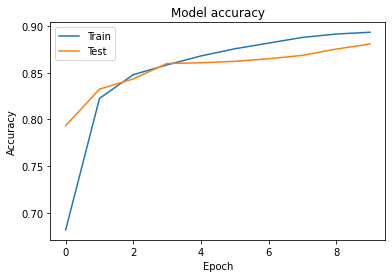

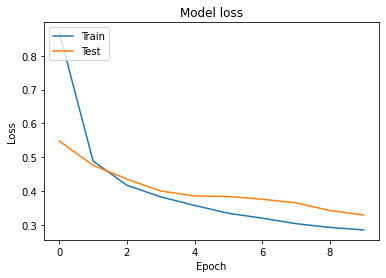

Time per epoch: [28.14643430709839, 19.782255172729492, 19.755688428878784, 20.12228536605835, 19.78737497329712, 19.782647371292114, 19.743024110794067, 19.728731632232666, 19.5998055934906, 19.561508893966675]
Total time: 206.00975584983826


In [25]:
#Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

In [26]:
#Necessito di un array con tutte le labels, ho già class_names

test_predictions = model_CNN_LSTM.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = class_names, 
                          columns = class_names)

[[835   0   6  23   6   1 117   0  12   0]
 [  4 965   1  25   2   0   2   0   1   0]
 [ 17   0 778  11 119   0  71   0   4   0]
 [ 21   4  11 891  29   1  39   0   4   0]
 [  2   2  77  40 845   0  34   0   0   0]
 [  0   0   0   1   0 949   0  31   0  19]
 [114   1  65  35 115   0 661   0   9   0]
 [  0   0   0   0   0  13   0 958   0  29]
 [  5   0   1   3   4   7   4   4 972   0]
 [  1   0   0   0   0   9   0  35   0 955]]


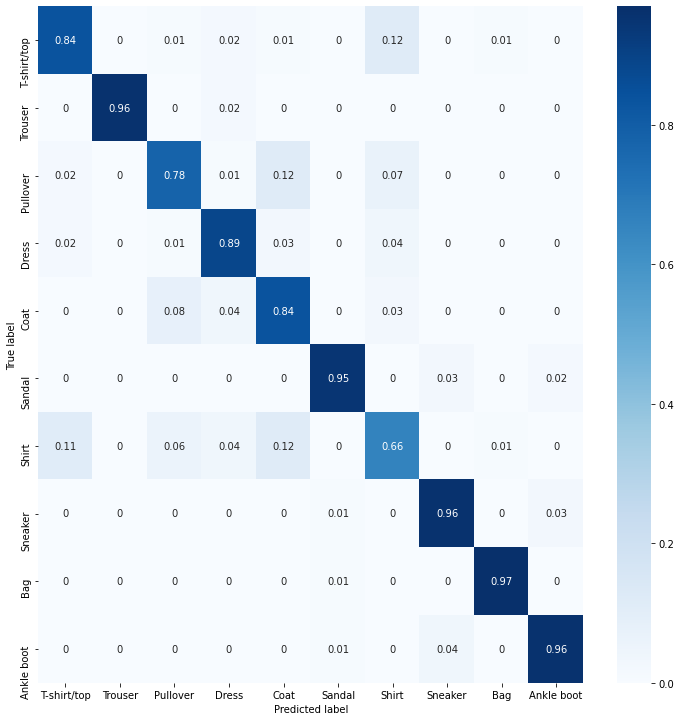

In [27]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()